In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import layers, regularizers, models, optimizers, losses, callbacks, metrics

In [213]:
# Columns
# has_diabetes: 0/1 (TARGET)
# age: integer
# sex: male/female
# hypertension: yes/no
# Enferemedad_vascular: yes/no
# Smoker: yes/no
# bmi: decimal
# Hba1c_cuan: decimal
# Hba1c_cual: normal/not normal
# random_glucose: decimal (maybe into cuantified/cualified setup)

## Entrenamiento del modelo

In [214]:
train_data_df = pd.read_csv('train_data.csv', index_col=0)
test_data_df = pd.read_csv('test_data.csv', index_col=0)
train_data_df['patient_id'] = train_data_df['patient_id'].astype(int)
test_data_df['patient_id'] = test_data_df['patient_id'].astype(int)
train_data_df.set_index('patient_id', inplace=True)
test_data_df.set_index('patient_id', inplace=True)
train_data_df.head()

,has_diabetes,age,gender,hypertension,heart_disease,smoker,bmi,glucose,hba1c,hba1c_cual,glucose_cual
patient_id,,,,,,,,,,,
82555,0.0,16.0,1.0,0.0,0.0,0.0,21.49,NaN,6.2,NaN,0.0
92299,0.0,15.0,1.0,0.0,0.0,0.0,33.62,158.0,NaN,0.0,0.0
18725,0.0,54.0,0.0,0.0,0.0,1.0,21.46,145.0,NaN,0.0,NaN
52208,1.0,54.0,1.0,0.0,0.0,0.0,39.12,NaN,NaN,1.0,1.0
2640,0.0,29.0,1.0,0.0,0.0,1.0,38.25,126.0,3.5,1.0,1.0


In [215]:
for na_col in train_data_df.columns[train_data_df.isna().sum() > 0]:
    train_data_df[na_col + '_is_na'] = train_data_df[na_col].isna().astype(int)
    test_data_df[na_col + '_is_na'] = test_data_df[na_col].isna().astype(int)
    median_value = train_data_df[na_col].median()
train_data_df.fillna(train_data_df.median(), inplace=True)
test_data_df.fillna(train_data_df.median(), inplace=True)
train_data_df.head()

,has_diabetes,age,gender,hypertension,heart_disease,smoker,bmi,glucose,hba1c,hba1c_cual,...,age_is_na,gender_is_na,hypertension_is_na,heart_disease_is_na,smoker_is_na,bmi_is_na,glucose_is_na,hba1c_is_na,hba1c_cual_is_na,glucose_cual_is_na
patient_id,,,,,,,,,,,,,,,,,,,,,
82555,0.0,16.0,1.0,0.0,0.0,0.0,21.49,145.0,6.2,1.0,...,0,0,0,0,0,0,1,0,1,0
92299,0.0,15.0,1.0,0.0,0.0,0.0,33.62,158.0,6.1,0.0,...,0,0,0,0,0,0,0,1,0,0
18725,0.0,54.0,0.0,0.0,0.0,1.0,21.46,145.0,6.1,0.0,...,0,0,0,0,0,0,0,1,0,1
52208,1.0,54.0,1.0,0.0,0.0,0.0,39.12,145.0,6.1,1.0,...,0,0,0,0,0,0,1,1,0,0
2640,0.0,29.0,1.0,0.0,0.0,1.0,38.25,126.0,3.5,1.0,...,0,0,0,0,0,0,0,0,0,0


In [216]:
train_embeddings_df = pd.read_csv('train_embeddings.csv', index_col=0)
test_embeddings_df = pd.read_csv('test_embeddings.csv', index_col=0)
train_embeddings_df.head()

,has_diabetes,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
patient_id,,,,,,,,,,,,,,,,,,,,,
82555,0,-0.038086,0.004242,0.002136,-0.012817,0.027954,0.049805,-0.034180,0.021362,0.020874,...,0.015076,0.037842,0.005890,0.057373,0.008362,-0.032959,-0.015076,0.044678,0.056885,0.005768
92299,0,-0.040039,-0.008545,0.002975,-0.022217,0.016235,0.064453,-0.071777,0.015198,-0.006256,...,-0.008240,0.028564,0.040527,0.034424,0.000000,-0.012146,-0.031982,0.000683,0.033203,0.010071
18725,0,-0.070801,-0.002518,0.001144,-0.003326,0.028931,0.007782,-0.061279,0.004883,-0.016724,...,-0.004456,-0.009766,0.010071,0.023804,0.003326,-0.034668,0.013977,0.026001,0.036133,-0.004547
52208,1,-0.079102,0.021851,0.003738,0.000205,-0.022949,0.061279,-0.062012,0.014282,0.010254,...,-0.020752,-0.000110,0.001900,0.031738,-0.028198,-0.011230,-0.034912,0.016968,0.030640,0.019775
2640,0,-0.056396,-0.000511,-0.000511,-0.007721,0.014954,0.063965,-0.073730,-0.000778,0.019043,...,-0.024780,0.031250,0.038330,0.037354,-0.028442,-0.020386,-0.052002,0.003464,0.022339,0.003128


In [217]:
train_sentiments_df = pd.read_csv('train_sentiments.csv', index_col=0)
test_sentiments_df = pd.read_csv('test_sentiments.csv', index_col=0)
train_sentiments_df.head()

,has_diabetes,sentiment,score
patient_id,,,
82555,0,0,0.964545
92299,0,0,0.979719
18725,0,1,0.628050
52208,1,0,0.810922
2640,0,0,0.936839


In [218]:
# Add sentiment columns to data df
train_data_df = train_data_df.join(train_sentiments_df.drop(columns=['has_diabetes']), on='patient_id')
test_data_df = test_data_df.join(test_sentiments_df, on='patient_id')


In [248]:
x_val_train_data = train_data_df.drop(columns=['has_diabetes'])
y_val_train = train_data_df['has_diabetes']
x_test_data = test_data_df.drop(columns=['has_diabetes'], errors='ignore')

In [229]:
val_ids = np.random.choice(x_val_train_data.index, size=int(0.2 * len(x_val_train_data)), replace=False)
x_val_data = x_val_train_data.loc[val_ids]
y_val = y_val_train.loc[val_ids]
x_train_data = x_val_train_data.drop(index=val_ids)
y_train = y_val_train.drop(index=val_ids)

In [262]:
x_embed_val_train = train_embeddings_df.drop(columns=['has_diabetes'], errors='ignore')
x_embed_train = x_embed_val_train.loc[x_train_data.index]
x_embed_val = x_embed_val_train.loc[x_val_data.index]
x_embed_test = test_embeddings_df.copy()

In [ ]:
keras.utils.set_random_seed(1234) 
activation = 'swish'
l_norm = 1e-4

x0 = layers.Input(shape=(x_train_data.shape[1],), name='data_input')
x1 = layers.Input(shape=(x_embed_train.shape[1],), name='embed_input')  # 1024
embed_nn = layers.Dense(256, activation=activation, kernel_regularizer=regularizers.l2(l_norm))(x1)
embed_nn = layers.Dense(64, activation=activation, kernel_regularizer=regularizers.l2(l_norm))(embed_nn)
embed_nn = layers.Dense(16, activation=activation, kernel_regularizer=regularizers.l2(l_norm))(embed_nn)
concat = layers.Concatenate()([x0, embed_nn])
dense_nn = layers.Dense(128, activation=activation, kernel_regularizer=regularizers.l2(l_norm))(concat)
dense_nn = layers.Dense(64, activation=activation, kernel_regularizer=regularizers.l2(l_norm))(dense_nn)
dense_nn = layers.Dense(32, activation=activation, kernel_regularizer=regularizers.l2(l_norm))(dense_nn)
output = layers.Dense(1, activation='sigmoid')(dense_nn)

model = models.Model(inputs=[x0, x1], outputs=output)
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-4),
    loss=losses.BinaryCrossentropy(),
    metrics=[
        metrics.AUC(name='auc'),
        metrics.F1Score(name='f1_score', threshold=0.34),
        metrics.BinaryAccuracy(name='accuracy', threshold=0.5)
    ]
)
model.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ embed_input         │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_172 (Dense)   │ (None, 256)       │    262,400 │ embed_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_173 (Dense)   │ (None, 64)        │     16,448 │ dense_172[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_input          │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_174 (Dense)   │ (None, 16)        │      1,040 │ dense_173[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 38)        │          0 │ data_input[0][0], │
│ (Concatenate)       │                   │            │ dense_174[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_175 (Dense)   │ (None, 128)       │      4,992 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_176 (Dense)   │ (None, 64)        │      8,256 │ dense_175[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_177 (Dense)   │ (None, 32)        │      2,080 │ dense_176[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_178 (Dense)   │ (None, 1)         │         33 │ dense_177[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 295,249 (1.13 MB)

 Trainable params: 295,249 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [264]:
history = model.fit([x_train_data, x_embed_train], y_train, epochs=100, batch_size=16, validation_split=0.2,
                    callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)])
print()
print('Training accuracy:', history.history['accuracy'][-1])
print('Training F1 Score:', history.history['f1_score'][-1])
print()
print('Validation accuracy:', history.history['val_accuracy'][-1])
print('Validation F1 Score:', history.history['val_f1_score'][-1])
# Validation F1 Score es una buena estimación de la performance del modelo en el set de 
# test, puesto que no ha habido data leakage.

Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6938 - auc: 0.6421 - f1_score: 0.4842 - loss: 0.7222 - val_accuracy: 0.7792 - val_auc: 0.8685 - val_f1_score: 0.5544 - val_loss: 0.5717
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8010 - auc: 0.8625 - f1_score: 0.6656 - loss: 0.4680 - val_accuracy: 0.8583 - val_auc: 0.9305 - val_f1_score: 0.7746 - val_loss: 0.3667
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ -2s -16692us/step - accuracy: 0.8354 - auc: 0.9030 - f1_score: 0.7304 - loss: 0.4053 - val_accuracy: 0.8625 - val_auc: 0.9378 - val_f1_score: 0.7855 - val_loss: 0.3426
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8427 - auc: 0.9104 - f1_score: 0.7356 - loss: 0.3910 - val_accuracy: 0.8771 - val_auc: 0.9422 - val_f1_score: 0.7881 - val_loss: 0.3310
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8495 - auc: 0.9151 - f1_score: 0.7391 - loss: 0.3812 - val_accuracy: 0.8833 - val_auc: 0.9448 - val_f1_score: 0.78

In [265]:
model.evaluate([x_val_data, x_embed_val], y_val)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8367 - auc: 0.9037 - f1_score: 0.7192 - loss: 0.4043


[0.4043397903442383,
 0.9036868214607239,
 0.7191600203514099,
 0.8366666436195374]

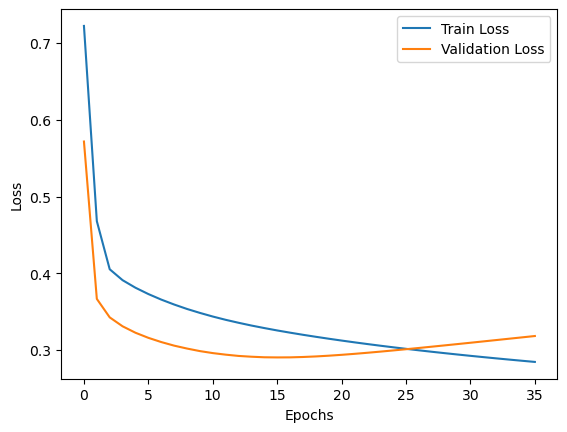

In [266]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 

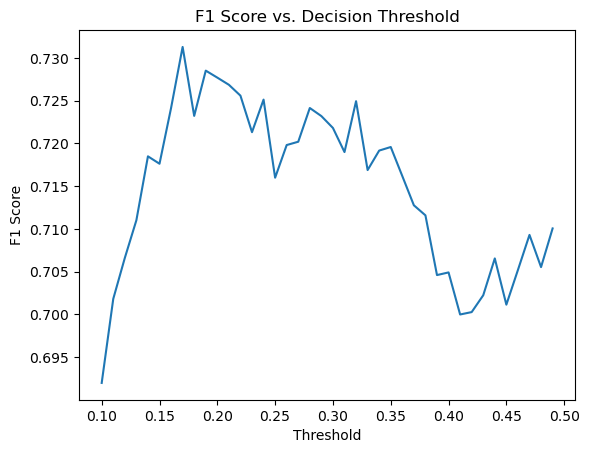

In [267]:
from sklearn.metrics import f1_score
thresholds = np.arange(0.1, 0.5, 0.01)
f1_scores = [f1_score(y_val, (model.predict([x_val_data, x_embed_val]) > t).astype("int32")) for t in thresholds]
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Decision Threshold')
plt.show()

np.float64(0.18999999999999995)

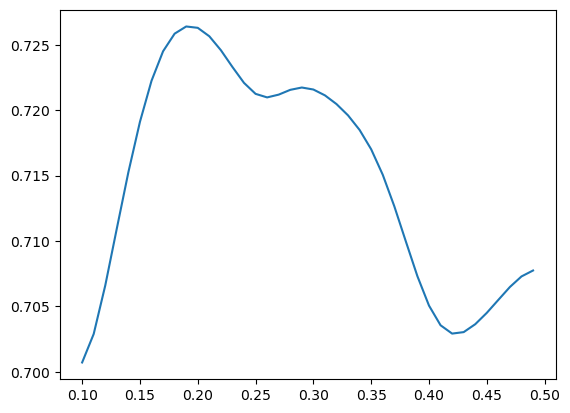

In [268]:
# Smooth f1_scores
from scipy.ndimage import gaussian_filter1d
smoothed_f1_scores = gaussian_filter1d(f1_scores, sigma=2)
plt.plot(thresholds, smoothed_f1_scores)
chosen_threshold = thresholds[smoothed_f1_scores.argmax()]
chosen_threshold

## Inferencia del modelo

In [269]:
# Entrenar con todo el dataset (hay una gran limitación de datos y cuantos más podamos aprovechar, mejor)
model.fit([x_val_train_data, x_embed_val_train], y_val_train, epochs=100, batch_size=16, validation_split=0.1,
          callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8589 - auc: 0.9309 - f1_score: 0.7684 - loss: 0.3470 - val_accuracy: 0.8700 - val_auc: 0.9632 - val_f1_score: 0.7426 - val_loss: 0.3126
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8626 - auc: 0.9333 - f1_score: 0.7701 - loss: 0.3414 - val_accuracy: 0.8800 - val_auc: 0.9652 - val_f1_score: 0.7400 - val_loss: 0.3022
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8622 - auc: 0.9348 - f1_score: 0.7766 - loss: 0.3375 - val_accuracy: 0.8800 - val_auc: 0.9662 - val_f1_score: 0.7400 - val_loss: 0.2951
Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8656 - auc: 0.9364 - f1_score: 0.7815 - loss: 0.3334 - val_accuracy: 0.8867 - val_auc: 0.9666 - val_f1_score: 0.7513 - val_loss: 0.2881
Epoch 5/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8663 - auc: 0.9376 - f1_score: 0.7825 - loss: 0.3304 - val_accuracy: 0.8867 - val_auc: 0.9669 - val_f1_score: 0.7475 - va

In [270]:
x_test_data

,age,gender,hypertension,heart_disease,smoker,bmi,glucose,hba1c,hba1c_cual,glucose_cual,...,hypertension_is_na,heart_disease_is_na,smoker_is_na,bmi_is_na,glucose_is_na,hba1c_is_na,hba1c_cual_is_na,glucose_cual_is_na,sentiment,score
patient_id,,,,,,,,,,,,,,,,,,,,,
37551,17.0,1.0,0.0,0.0,0.0,18.89,145.0,6.1,0.0,0.0,...,0,0,0,0,1,1,0,0,1,0.963829
24430,38.0,1.0,0.0,0.0,1.0,26.29,85.0,6.1,0.0,0.0,...,0,0,0,0,0,1,0,0,1,0.651580
89346,45.0,0.0,1.0,0.0,1.0,26.00,200.0,6.1,1.0,1.0,...,0,0,0,0,0,1,0,0,0,0.910420
88818,51.0,1.0,0.0,0.0,1.0,32.76,200.0,7.5,1.0,1.0,...,0,0,0,0,0,0,1,0,0,0.972550
139,50.0,1.0,0.0,0.0,0.0,35.00,145.0,5.0,1.0,0.0,...,0,0,0,0,1,0,1,0,1,0.964616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78241,23.0,0.0,0.0,0.0,0.0,29.12,145.0,6.1,0.0,0.0,...,0,0,0,0,1,1,0,0,0,0.987874
30126,32.0,0.0,0.0,0.0,1.0,27.32,280.0,6.8,1.0,1.0,...,0,0,0,0,0,0,1,0,0,0.970634
82131,51.0,0.0,0.0,0.0,0.0,14.80,145.0,6.0,1.0,1.0,...,0,0,0,0,1,0,1,0,0,0.951349


In [271]:
test_data_df['has_diabetes'] = (model.predict([x_test_data, x_embed_test]) > chosen_threshold).astype("int32")
result_df = test_data_df[['has_diabetes']]
result_df.reset_index(inplace=True)
result_df['patient_id'] = 'patient_' + result_df['patient_id'].astype(str).str.zfill(5)
result_df.to_csv('predictions-complex-keras.csv', index=False)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/tmp/ipykernel_301645/4238151164.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['patient_id'] = 'patient_' + result_df['patient_id'].astype(str).str.zfill(5)
